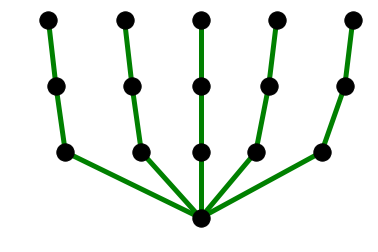

In [66]:
%config IPCompleter.greedy=True
%matplotlib inline
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout, to_agraph
import matplotlib.pyplot as plt
from copy import deepcopy
class Graph:
    def __init__(self):
        self.nodecolors = {}
        self.G = nx.DiGraph()
        self.counter=0
        self.roots=[]
    
    def drawGraph(self):
        plt.gca().invert_yaxis()
        pos =graphviz_layout(self.G, prog='dot')
        edges = self.G.edges()
        colors = [self.nodecolors[u][v] for u,v in edges]
        nx.draw(self.G, pos, with_labels=False, arrows=False, edge_color=colors, node_color='black', width=5)
        plt.show()

    def add_edge(self, From, To, color='black'):
        self.G.add_edge(From,To)
        if From in self.nodecolors:
            self.nodecolors[From][To] = color
        else:
            self.nodecolors[From] = {To:color}

    def createGraph(self):
        self.G.add_node("ROOT")
        for i in range(5):
            self.G.add_node("Child_%i" % i)
            self.G.add_node("Grandchild_%i" % i)
            self.G.add_node("Greatgrandchild_%i" % i)
            self.add_edge("ROOT", "Child_%i" % i,'g')
            self.add_edge("Child_%i" % i, "Grandchild_%i" % i,'g')
            self.add_edge("Grandchild_%i" % i, "Greatgrandchild_%i" % i,'g')
    
    def remove_node(self,node):
        if node in self.G.nodes():
            nodes = deepcopy(self.G[node])
            for v in nodes:
                self.remove_edge(node,v)
            self.G.remove_node(node)
        
    
    def remove_edge(self,From,To):
        if From in self.G and To in self.G[From]:
            self.G.remove_edge(From,To)
            self.nodecolors[From].pop(To,None)
            self.remove_node(To)
        

G = Graph()            
G.createGraph()
G.drawGraph()

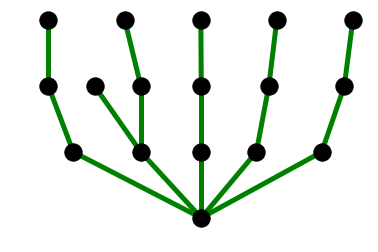

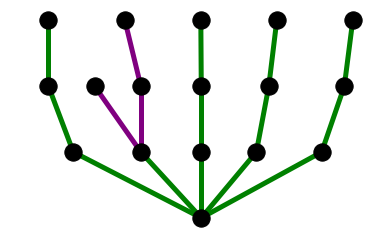

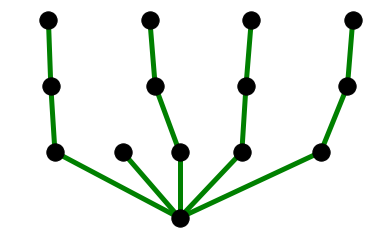

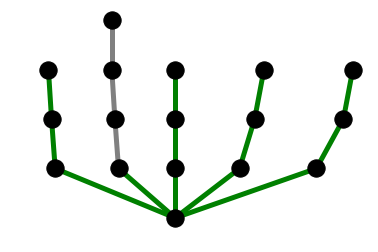

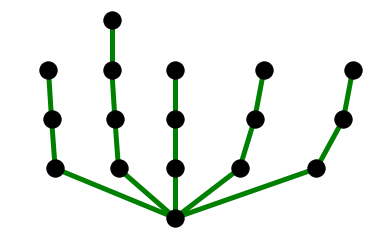

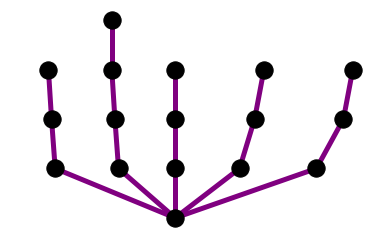

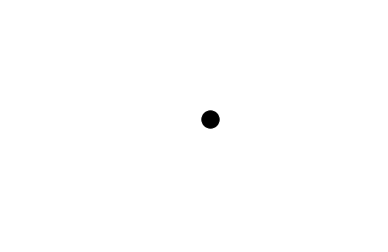

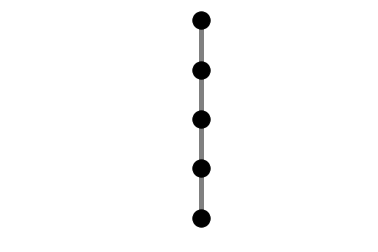

5

In [58]:
def change_color(G,node,col):
    for child in G.G[node]:
        G.nodecolors[node][child]=col
        change_color(G,child,col)   
        
def add_chain(G,node,length):
    if(length==0):
        return
#     print(node,G.counter)
    G.add_edge(node,G.counter,'grey')
    G.counter+=1
    add_chain(G,G.counter-1,length-1)
def dfs(G,node):
    if len(G.G[node])==0:
        return 1
    
#     print(node)
    sz=0
    xor_value=0
    for child in G.G[node]:
        chain_len=dfs(G,child)
        sz+=chain_len
        xor_value^=chain_len
    if len(G.G[node])==1:
        return sz+1
    G.drawGraph()
    change_color(G,node,'purple')
    G.drawGraph()
    adj_list=deepcopy(G.G[node])
    for child in adj_list:
#         print(node,child)
        G.remove_edge(node,child)
    G.drawGraph()
#     print(sz,xor_value)
    if xor_value==0:
        return 1
    add_chain(G,node,xor_value)
    G.drawGraph()
    change_color(G,node,'g')
#     G.drawGraph()
    return xor_value+1
G.add_edge("Child_1","5",'g')
dfs(G,"ROOT")

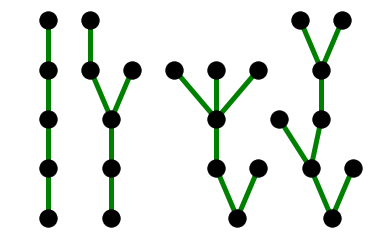

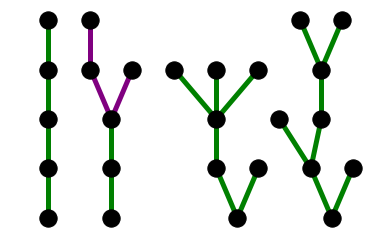

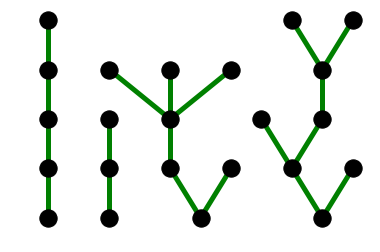

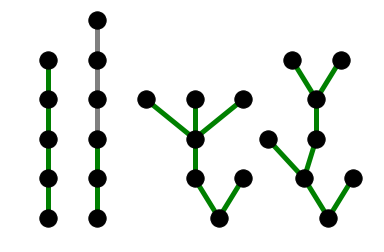

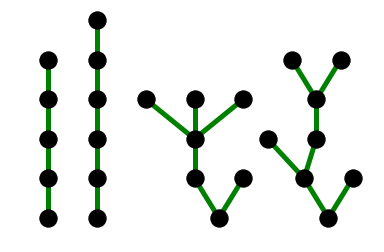

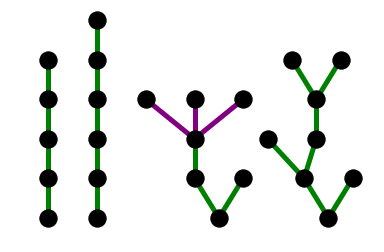

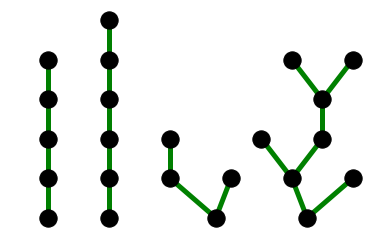

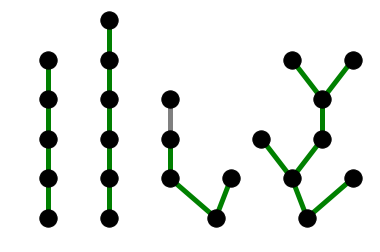

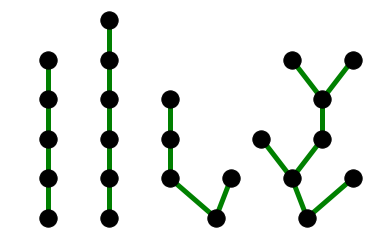

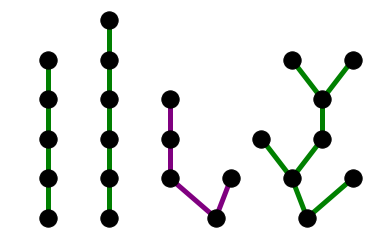

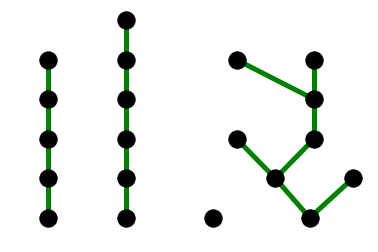

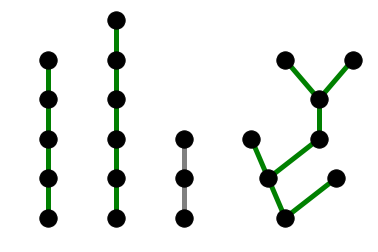

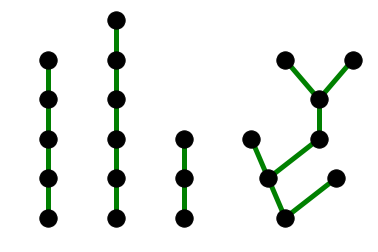

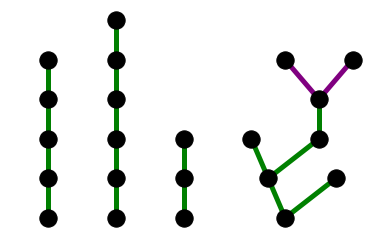

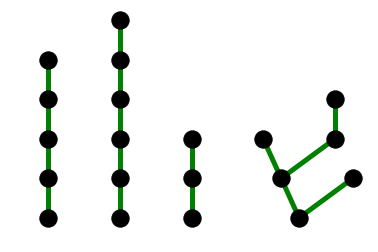

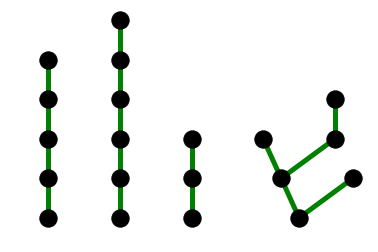

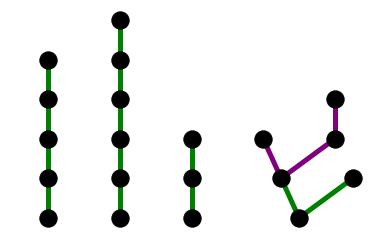

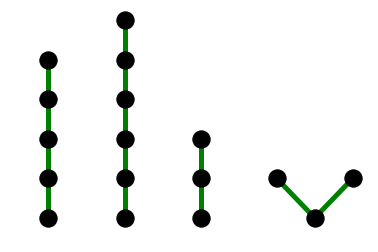

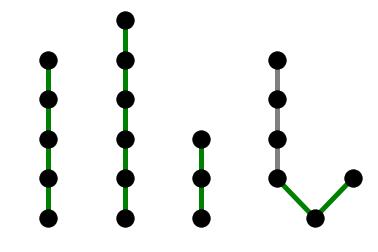

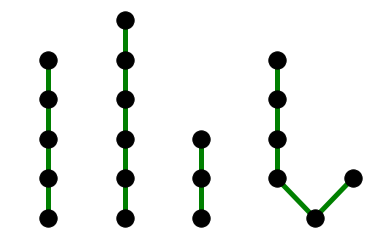

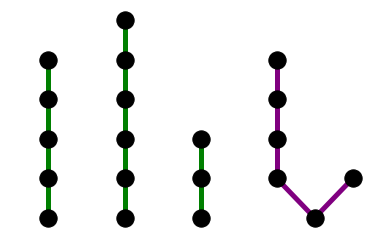

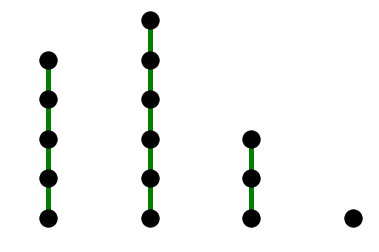

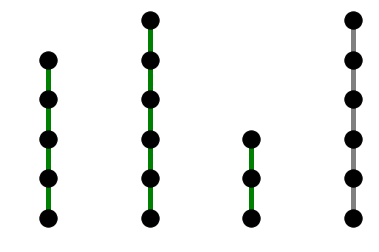

In [68]:
def dfs_add(G,node,ans,parent):
    for child in G[node]:
        if child==parent:
            continue
        ans.add_edge(node+ans.counter,child+ans.counter,'g')
        dfs_add(G,child,ans,node)
        
def convert_graph(G,ans):
    ans.roots.append(ans.counter)
    dfs_add(G,0,ans,-1)
    ans.counter+=len(G.node())
    
def get_forest(nlist):
    ans=Graph()
    for i in nlist:
        convert_graph(nx.random_tree(i),ans)
    return ans

rt1=get_forest([5,6,7,8])
for root in rt1.roots:
    dfs(rt1,root)